In [2]:
!pip install fredapi
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Data Collection

#Apple stock history
stock_data = yf.download('AAPL', start='2015-01-01', end='2024-01-01')

fred = Fred(api_key='NA')


#interest rate fetch
interest_rate = fred.get_series('DGS10', start_date='2015-01-01', end_date='2024-01-01')

#inflation rate fetch
inflation_rate = fred.get_series('CPIAUCSL', start_date='2015-01-01', end_date='2024-01-01').pct_change() * 100

#GDP fetch
gdp_growth = fred.get_series('A191RL1Q225SBEA', start_date='2015-01-01', end_date='2024-01-01')

#convert into pandas readable format
gdp_growth = pd.DataFrame(gdp_growth)
gdp_growth.index = pd.to_datetime(gdp_growth.index) #convert into pandas date and time

#NA or not
print(gdp_growth.index)  #

# check for quarterly NA
gdp_growth_daily = gdp_growth.resample('D').ffill() 

#Merge the data
economic_data = pd.DataFrame({
    'Interest_Rate': interest_rate,
    'Inflation_Rate': inflation_rate,
    'GDP_Growth': gdp_growth_daily.squeeze()  #conver back to series
})

#Merge based off of dates 
df = stock_data[['Adj Close']].merge(economic_data, left_index=True, right_index=True)

#percentage change calculation
df['Stock_Return'] = df['Adj Close'].pct_change().dropna()

#NA
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['1947-04-01', '1947-07-01', '1947-10-01', '1948-01-01',
               '1948-04-01', '1948-07-01', '1948-10-01', '1949-01-01',
               '1949-04-01', '1949-07-01',
               ...
               '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01',
               '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01',
               '2024-01-01', '2024-04-01'],
              dtype='datetime64[ns]', length=309, freq=None)


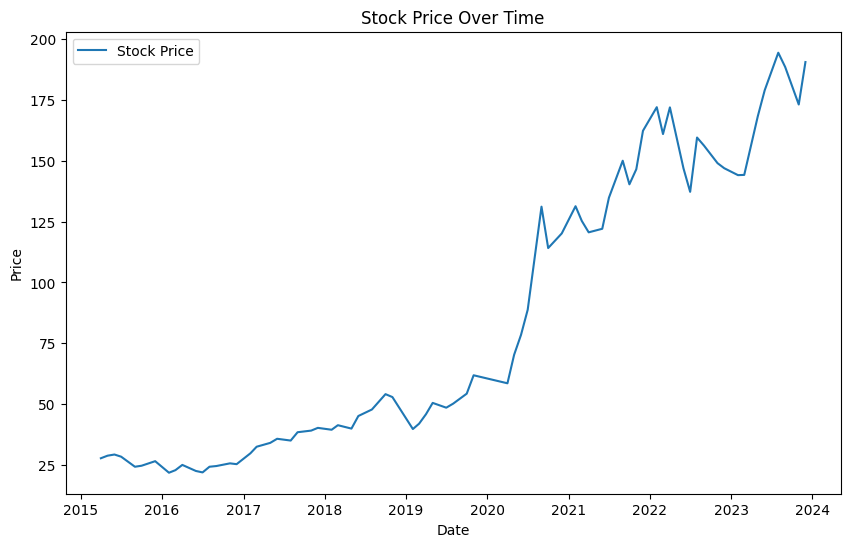

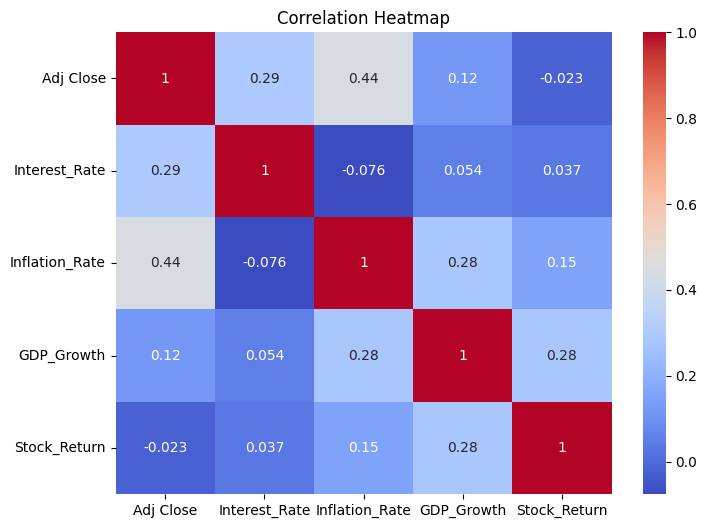

In [4]:


#Plot graphs stock prices vs economic factors
plt.figure(figsize=(10,6))
plt.plot(df['Adj Close'], label='Stock Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#heat map
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Mean Absolute Error: 0.022063998670553857
R-squared: -0.020235500230954884


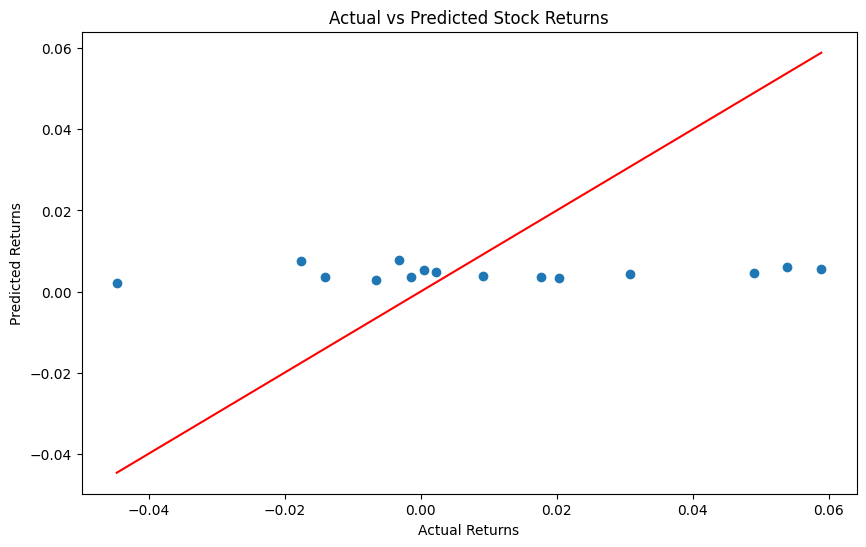

In [6]:


#Define independent variable(factors)
X = df[['Interest_Rate', 'Inflation_Rate', 'GDP_Growth']]

#Define dependent
y = df['Stock_Return']

#Training and test conditions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()

model.fit(X_train, y_train)



#prediction values
y_pred = model.predict(X_test)

#calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

#calculate R squared 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

#Predicted vs actual graphs
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Actual vs Predicted Stock Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.show()

In [7]:



coefficients = pd.DataFrame({
    'Feature': ['Interest_Rate', 'Inflation_Rate', 'GDP_Growth'],
    'Coefficient': model.coef_
})

print("Model Coefficients:")
print(coefficients)

#Data Summary
print(f"\nModel Summary:\nR-squared: {r2}\nMAE: {mae}")

Model Coefficients:
          Feature  Coefficient
0   Interest_Rate     0.001502
1  Inflation_Rate     0.003999
2      GDP_Growth     0.000554

Model Summary:
R-squared: -0.020235500230954884
MAE: 0.022063998670553857
